<a href="https://colab.research.google.com/github/nicolai5965/-MNIST-Handwritten-Digit-Recognition-TensorFlow/blob/main/MNIST_CNN_Prediction_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

Loading the MNIST dataset from TensorFlow´s datasets

In [2]:
# Load the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True, split='train+test')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
mnist_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Pre processing of the data, and splitting the data up in training, validation and testing datasets. 

In [4]:
import collections
import random
import tensorflow as tf
import pandas as pd
import numpy as np

def prepare_image_data(data, data_usage_ratio=1.0, batch_size=64, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, scaling_factor=255.):
    assert train_ratio + validation_ratio + test_ratio == 1.0, "The sum of train_ratio, validation_ratio, and test_ratio must be 1."

    # Convert TensorFlow Dataset to a list of (image, label) tuples
    data_list = list(data.as_numpy_iterator())

    # Convert the list to a Pandas DataFrame
    df = pd.DataFrame(data_list, columns=['image', 'label'])

    # Apply the scaling function using Pandas
    df['image'] = df['image'].apply(lambda x: (x.astype(np.float32) / scaling_factor))

    # Group data by class (label) and shuffle each group
    grouped_data = df.groupby('label').apply(lambda x: x.sample(frac=data_usage_ratio, random_state=42))

    # Perform stratified shuffling
    stratified_data = grouped_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the number of training, validation, and test samples
    num_total_samples = len(stratified_data)
    num_train_samples = int(train_ratio * num_total_samples)
    num_validation_samples = int(validation_ratio * num_total_samples)
    num_test_samples = int(test_ratio * num_total_samples)

    # Split the dataset into training, validation, and test datasets
    train_data = stratified_data[:num_train_samples]
    validation_data = stratified_data[num_train_samples:num_train_samples + num_validation_samples]
    test_data = stratified_data[num_train_samples + num_validation_samples:]

    # Convert the DataFrames back to TensorFlow Dataset objects
    train_data = tf.data.Dataset.from_tensor_slices((train_data['image'].to_list(), train_data['label'].to_list())).batch(batch_size).prefetch(1)
    validation_data = tf.data.Dataset.from_tensor_slices((validation_data['image'].to_list(), validation_data['label'].to_list())).batch(num_validation_samples)
    test_data = tf.data.Dataset.from_tensor_slices((test_data['image'].to_list(), test_data['label'].to_list())).batch(num_test_samples)

    # Extract the inputs and targets from the validation dataset
    validation_inputs, validation_targets = next(iter(validation_data))

    return train_data, validation_data, validation_inputs, validation_targets, test_data

In [5]:
%%time
# Call the prepare_image_data() function
train_data, validation_data, validation_inputs, validation_targets, test_data = prepare_image_data(mnist_dataset, data_usage_ratio=1.0, batch_size=64, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, scaling_factor=255)

# Check the distribution of targets in the validation_targets
unique_targets, target_counts = np.unique(validation_targets, return_counts=True)
print("Target distribution:", dict(zip(unique_targets, target_counts)))

# Check if the target counts are approximately the same
tolerance = 0.1  # Adjust this value to control how similar the target counts should be
min_count = np.min(target_counts)
max_count = np.max(target_counts)
if max_count <= min_count * (1 + tolerance):
    print("The target counts in the validation set are approximately the same.")
else:
    print("The target counts in the validation set are not approximately the same.")


Target distribution: {0: 694, 1: 808, 2: 713, 3: 689, 4: 663, 5: 612, 6: 713, 7: 709, 8: 713, 9: 686}
The target counts in the validation set are not approximately the same.
CPU times: user 1min 39s, sys: 4.46 s, total: 1min 43s
Wall time: 1min 42s


In [6]:
# Get the number of samples in the dataset
num_samples = 0
for batch in train_data:
    num_samples += len(batch[0])

# Get the shape of an individual sample
sample_shape = train_data.element_spec[0].shape[1:]

print(f"Number of samples: {num_samples}")
print(f"Sample shape: {sample_shape}")


Number of samples: 56000
Sample shape: (28, 28, 1)


In [7]:
# Model configuration
config = {
    'input_shape': sample_shape,
    'conv1': {'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'SAME', 'activation': 'relu', 'regularizer': regularizers.l2(0.001)},
    'pool1': {'size': (2, 2), 'strides': (2, 2), 'padding': 'VALID'},
    'conv2': {'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'SAME', 'activation': 'relu', 'regularizer': regularizers.l2(0.001)},
    'pool2': {'size': (2, 2), 'strides': (2, 2), 'padding': 'VALID'},
    'conv3': {'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'SAME', 'activation': 'relu', 'regularizer': regularizers.l2(0.001)},
    'pool3': {'size': (2, 2), 'strides': (2, 2), 'padding': 'VALID'},
    'dense1': {'units': 128, 'activation': 'relu', 'regularizer': regularizers.l2(0.001)},
    'dense2': {'units': 64, 'activation': 'relu', 'regularizer': regularizers.l2(0.001)},
    'output': {'units': 10, 'activation': 'softmax'},
    'optimizer': 'adam',
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 20,
    'verbose': 2
}

# Creating the model
model = Sequential([
    Conv2D(filters=config['conv1']['filters'], kernel_size=config['conv1']['kernel_size'], strides=config['conv1']['strides'], padding=config['conv1']['padding'], activation=config['conv1']['activation'], kernel_regularizer=config['conv1']['regularizer'], input_shape=config['input_shape']),
    MaxPooling2D(pool_size=config['pool1']['size'], strides=config['pool1']['strides'], padding=config['pool1']['padding']),
    Conv2D(filters=config['conv2']['filters'], kernel_size=config['conv2']['kernel_size'], strides=config['conv2']['strides'], padding=config['conv2']['padding'], activation=config['conv2']['activation'], kernel_regularizer=config['conv2']['regularizer']),
    MaxPooling2D(pool_size=config['pool2']['size'], strides=config['pool2']['strides'], padding=config['pool2']['padding']),
    Conv2D(filters=config['conv3']['filters'], kernel_size=config['conv3']['kernel_size'], strides=config['conv3']['strides'], padding=config['conv3']['padding'], activation=config['conv3']['activation'], kernel_regularizer=config['conv3']['regularizer']),
    MaxPooling2D(pool_size=config['pool3']['size'], strides=config['pool3']['strides'], padding=config['pool3']['padding']),
    Flatten(),
    Dense(units=config['dense1']['units'], activation=config['dense1']['activation'], kernel_regularizer=config['dense1']['regularizer']),
    Dense(units=config['dense2']['units'], activation=config['dense2']['activation'], kernel_regularizer=config['dense2']['regularizer']),
    Dense(units=config['output']['units'], activation=config['output']['activation'])
])

# Early stopping configuration
early_stopping_config = {
    'monitor': 'val_loss',
    'patience': 3,
    'restore_best_weights': True,
    'verbose': 2
}
# Creating the early stopping callback
early_stopping = EarlyStopping(monitor=early_stopping_config['monitor'], patience=early_stopping_config['patience'], restore_best_weights=early_stopping_config['restore_best_weights'], verbose=early_stopping_config['verbose'])


# Compiling the model
model.compile(optimizer=config['optimizer'], loss=config['loss'], metrics=config['metrics'])


In [8]:
%%time
history = model.fit(train_data, epochs=config['epochs'], validation_data=(validation_inputs, validation_targets), verbose=config['verbose'], callbacks=[early_stopping])
# Evaluating the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print("Test loss: {0:.4f}, test accuracy: {1:.4f}".format(test_loss, test_accuracy))


Epoch 1/20
875/875 - 17s - loss: 0.4331 - accuracy: 0.9381 - val_loss: 0.2668 - val_accuracy: 0.9721 - 17s/epoch - 19ms/step
Epoch 2/20
875/875 - 4s - loss: 0.2163 - accuracy: 0.9800 - val_loss: 0.1910 - val_accuracy: 0.9806 - 4s/epoch - 5ms/step
Epoch 3/20
875/875 - 5s - loss: 0.1665 - accuracy: 0.9829 - val_loss: 0.1688 - val_accuracy: 0.9777 - 5s/epoch - 5ms/step
Epoch 4/20
875/875 - 4s - loss: 0.1433 - accuracy: 0.9847 - val_loss: 0.1532 - val_accuracy: 0.9784 - 4s/epoch - 5ms/step
Epoch 5/20
875/875 - 4s - loss: 0.1322 - accuracy: 0.9849 - val_loss: 0.1504 - val_accuracy: 0.9781 - 4s/epoch - 5ms/step
Epoch 6/20
875/875 - 4s - loss: 0.1247 - accuracy: 0.9861 - val_loss: 0.1420 - val_accuracy: 0.9794 - 4s/epoch - 5ms/step
Epoch 7/20
875/875 - 4s - loss: 0.1181 - accuracy: 0.9867 - val_loss: 0.1255 - val_accuracy: 0.9841 - 4s/epoch - 5ms/step
Epoch 8/20
875/875 - 4s - loss: 0.1135 - accuracy: 0.9874 - val_loss: 0.1157 - val_accuracy: 0.9857 - 4s/epoch - 5ms/step
Epoch 9/20
875/875 - 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [10]:
def plot_loss_and_accuracy_curves(history):
    plt.figure(figsize=(12, 4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

def plot_confusion_matrix(test_data, model):
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.argmax(model.predict(test_data), axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_feature_maps(model, test_data):
    feature_map_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

    image, _ = next(iter(test_data.take(1)))
    image = image[0:1]

    feature_maps = feature_map_model.predict(image)

    num_feature_maps = feature_maps.shape[-1]
    rows = int(np.sqrt(num_feature_maps))
    cols = int(np.ceil(num_feature_maps / rows))

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(num_feature_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')

    plt.suptitle('Feature Maps')
    plt.show()


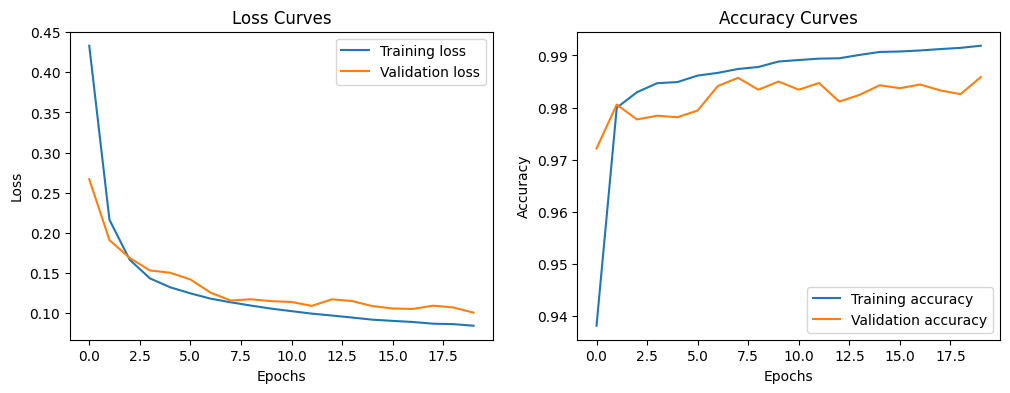

1/1 [==============================] - 0s 121ms/step


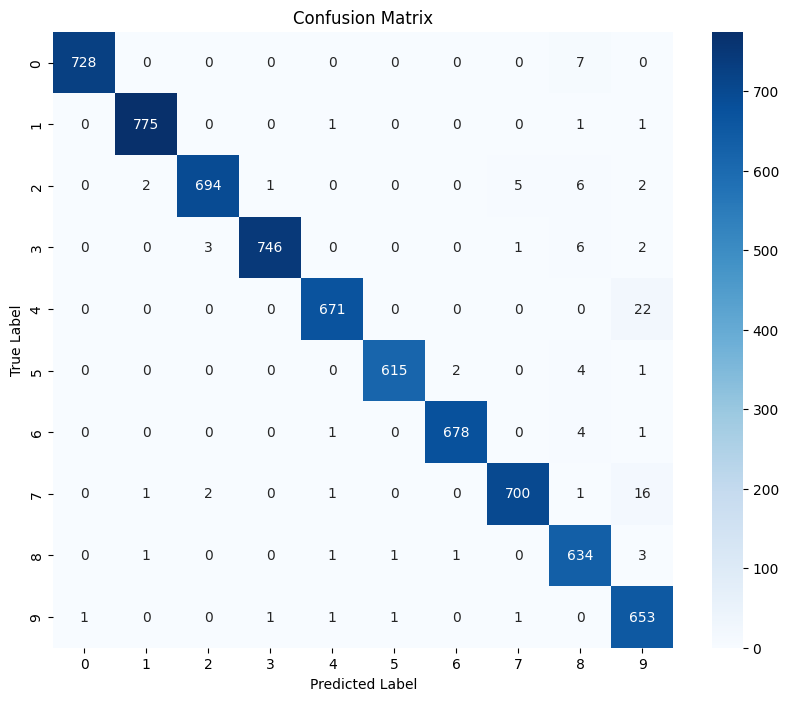

1/1 [==============================] - 0s 55ms/step


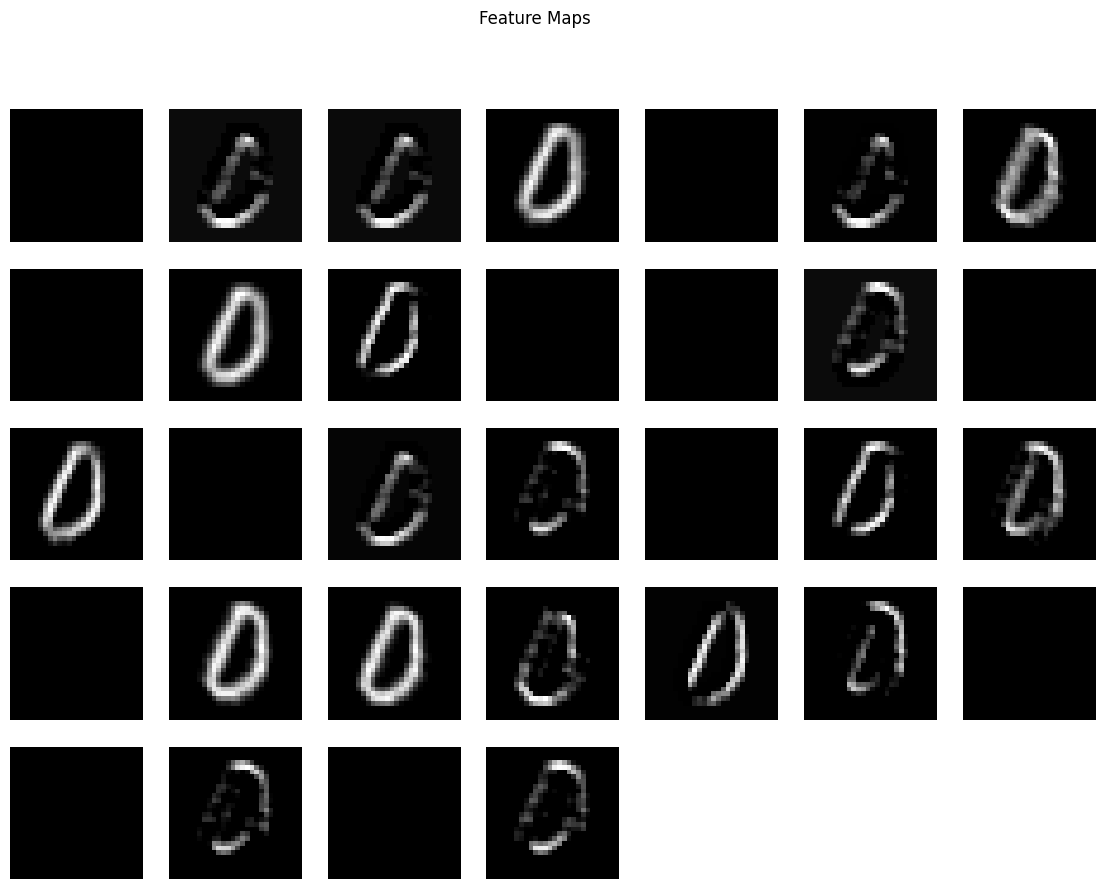

In [11]:
# Plot the loss and accuracy curves
plot_loss_and_accuracy_curves(history)

# Plot the confusion matrix
plot_confusion_matrix(test_data, model)

# Plot the feature maps
plot_feature_maps(model, test_data)